<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
def get_dataloader(image_size, batch_size):
    """
      Builds dataloader for training data.
      Use tt.Compose and tt.Resize for transformations
      :param image_size: height and wdith of the image
      :param batch_size: batch_size of the dataloader
      :returns: DataLoader object 
    """
    transforms = tt.Compose([tt.Resize(image_size),
                            tt.CenterCrop(image_size),
                            tt.ToTensor(),
                            tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset_ = ImageFolder(root = '/kaggle/input/faces-dataset-small', transform=transforms)
    dataloader = DataLoader(dataset=dataset_, batch_size=batch_size)
    return dataloader
  # TODO: resize images, convert them to tensors and build dataloader
  

In [4]:
image_size = 128
batch_size = 32

dataloader = get_dataloader(image_size, batch_size)

#TODO: build dataloader and transfer it to device

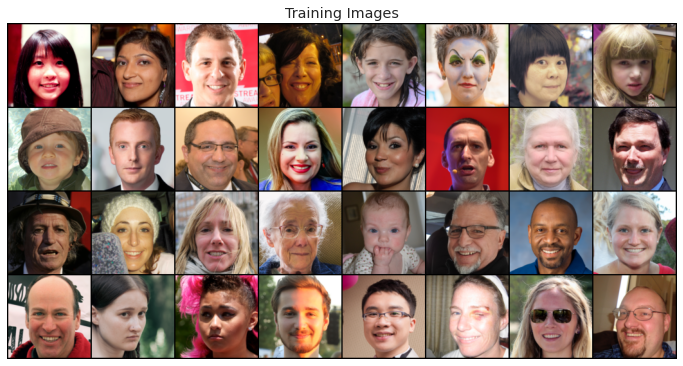

In [5]:
batch, _ = next(iter(dataloader))

plt.figure(figsize=(12, 12))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(batch.to(device), padding=2, normalize=True).cpu(),(1,2,0)))

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [40]:
class Discriminator(nn.Module):
    def __init__(self, input_channels, num_filters):
        super(Discriminator, self).__init__()
        self.num_filters = num_filters
        self.conv1 = nn.Conv2d(input_channels, num_filters, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(num_filters, num_filters*2, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(num_filters*2, num_filters*4, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(num_filters*4, num_filters*8, kernel_size=4, stride=2, padding=1)
        self.conv5 = nn.Conv2d(num_filters*8, num_filters*16, kernel_size=4, stride=2, padding=1)
        self.fc = nn.Linear(in_features=num_filters*16*4*4, out_features=1)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky_relu(x)
        x = self.conv2(x)
        x = self.leaky_relu(x)
        x = self.conv3(x)
        x = self.leaky_relu(x)
        x = self.conv4(x)
        x = self.leaky_relu(x)
        x = self.conv5(x)
        x = self.leaky_relu(x)
        x = x.view(-1, self.num_filters*16*4*4)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [41]:
latent_size = 128

class Generator(nn.Module):
    def __init__(self, latent_size, num_filters):
        super(Generator, self).__init__()
        
        self.num_filters = num_filters
        
        self.fc = nn.Linear(latent_size, num_filters*16*4*4)
        self.conv1 = nn.ConvTranspose2d(in_channels=num_filters*16,
                                        out_channels=num_filters*8,
                                        kernel_size=4,
                                        stride=2,
                                        padding=1)

        self.conv2 = nn.ConvTranspose2d(in_channels=num_filters*8,
                                        out_channels=num_filters*4,
                                        kernel_size=4,
                                        stride=2,
                                        padding=1)

        self.conv3 = nn.ConvTranspose2d(in_channels=num_filters*4,
                                        out_channels=num_filters*2,
                                        kernel_size=4,
                                        stride=2,
                                        padding=1)

        self.conv4 = nn.ConvTranspose2d(in_channels=num_filters*2,
                                        out_channels=num_filters,
                                        kernel_size=4,
                                        stride=2,
                                        padding=1)

        self.conv5 = nn.ConvTranspose2d(in_channels=num_filters,
                                        out_channels=3,
                                        kernel_size=4,
                                        stride=2,
                                        padding=1)
        
        
        self.tanh = nn.Tanh()
        
    def forward(self, z):
        z = self.fc(z)
        z = z.view(-1, self.num_filters*16, 4, 4)
        z = self.conv1(z)
        z = self.tanh(z)
        z = self.conv2(z)
        z = self.tanh(z)
        z = self.conv3(z)
        z = self.tanh(z)
        z = self.conv4(z)
        z = self.tanh(z)
        z = self.conv5(z)
        z = self.tanh(z)
        return z
        



Сконструируйте генератор и дискриминатор. Помните, что:

    дискриминатор принимает на вход изображение (тензор размера 3 x image_size x image_size) и выдает вероятность того, что изображение настоящее (тензор размера 1)

    генератор принимает на вход тензор шумов размера latent_size x 1 x 1 и генерирует изображение размера 3 x image_size x image_size



In [45]:
lr = 0.0001

model = {
    "discriminator": Discriminator(3, image_size),
    "generator": Generator(latent_size, image_size)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [46]:
def fit(model, dataloader, criterion, epochs, lr):
    model['discriminator'].to(device)
    model['generator'].to(device)
    model['discriminator'].train()
    model['generator'].train()
    torch.cuda.empty_cache()
    
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    optimizer = {
        "discriminator": torch.optim.AdamW(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.AdamW(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(dataloader):
            real_images = real_images.to(device)
            optimizer['discriminator'].zero_grad()
            real_preds = model['discriminator'](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion['discriminator'](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            latent = torch.randn(batch_size, latent_size, device=device)
            fake_images = model['generator'](latent)
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()
            
            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)
            
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer['discriminator'].step()
            loss_d_per_epoch.append(loss_d.item())
            
            
            optimizer['generator'].zero_grad()
            latent = torch.randn(batch_size, latent_size, device=device)
            fake_images = model["generator"](latent)
            
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
        
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        if (epoch+1)%10 == 0:
            plt.figure(figsize=(12,12))
            plt.axis("off")
            plt.title("Generated Images")
            plt.imshow(np.transpose(make_grid(fake_images.to(device)[:16], padding=2, normalize=True).cpu(),(1,2,0)))
            plt.show()
    
    return losses_g, losses_d, real_scores, fake_scores
    

  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [1/40], loss_g: 2.3983, loss_d: 0.9779, real_score: 0.7163, fake_score: 0.3248


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [2/40], loss_g: 1.3571, loss_d: 1.1680, real_score: 0.5966, fake_score: 0.4124


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [3/40], loss_g: 1.0863, loss_d: 1.2602, real_score: 0.5639, fake_score: 0.4531


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [4/40], loss_g: 1.0850, loss_d: 1.2267, real_score: 0.5781, fake_score: 0.4412


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [5/40], loss_g: 1.1928, loss_d: 1.2168, real_score: 0.5835, fake_score: 0.4287


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [6/40], loss_g: 1.3262, loss_d: 1.1400, real_score: 0.6195, fake_score: 0.4090


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [7/40], loss_g: 1.4410, loss_d: 1.0702, real_score: 0.6543, fake_score: 0.3785


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [8/40], loss_g: 1.9303, loss_d: 0.9349, real_score: 0.7184, fake_score: 0.3155


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [9/40], loss_g: 2.1390, loss_d: 0.9263, real_score: 0.7192, fake_score: 0.2954


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [10/40], loss_g: 2.3360, loss_d: 0.7324, real_score: 0.7738, fake_score: 0.2589


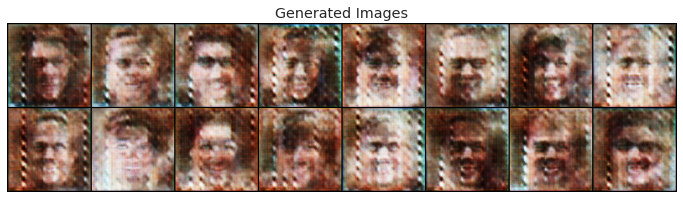

  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [11/40], loss_g: 2.1079, loss_d: 1.0190, real_score: 0.7067, fake_score: 0.2982


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [12/40], loss_g: 2.3042, loss_d: 0.7176, real_score: 0.7819, fake_score: 0.2431


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [13/40], loss_g: 2.3365, loss_d: 0.7357, real_score: 0.7650, fake_score: 0.2420


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [14/40], loss_g: 2.1658, loss_d: 0.7581, real_score: 0.7514, fake_score: 0.2556


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [15/40], loss_g: 2.4263, loss_d: 0.6452, real_score: 0.7910, fake_score: 0.2176


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [16/40], loss_g: 2.4872, loss_d: 0.6040, real_score: 0.8025, fake_score: 0.2063


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [17/40], loss_g: 2.5329, loss_d: 0.6322, real_score: 0.8028, fake_score: 0.2066


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [18/40], loss_g: 2.5081, loss_d: 0.6380, real_score: 0.7977, fake_score: 0.2062


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [19/40], loss_g: 2.8162, loss_d: 0.5574, real_score: 0.8275, fake_score: 0.1822


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [20/40], loss_g: 2.7833, loss_d: 0.5618, real_score: 0.8274, fake_score: 0.1813


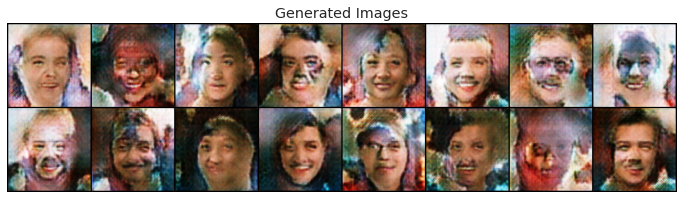

  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [21/40], loss_g: 2.9961, loss_d: 0.4953, real_score: 0.8410, fake_score: 0.1651


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [22/40], loss_g: 3.2317, loss_d: 0.4978, real_score: 0.8461, fake_score: 0.1587


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [23/40], loss_g: 3.4185, loss_d: 1.2881, real_score: 0.8567, fake_score: 0.1598


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [24/40], loss_g: 2.5478, loss_d: 0.6536, real_score: 0.7897, fake_score: 0.2239


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [25/40], loss_g: 3.4765, loss_d: 0.3864, real_score: 0.8724, fake_score: 0.1341


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [26/40], loss_g: 3.4781, loss_d: 0.4534, real_score: 0.8612, fake_score: 0.1459


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [27/40], loss_g: 3.4804, loss_d: 0.4940, real_score: 0.8538, fake_score: 0.1492


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [28/40], loss_g: 3.4940, loss_d: 0.4128, real_score: 0.8706, fake_score: 0.1349


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [29/40], loss_g: 4.0551, loss_d: 0.3037, real_score: 0.9032, fake_score: 0.0992


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [30/40], loss_g: 3.8369, loss_d: 0.4316, real_score: 0.8733, fake_score: 0.1323


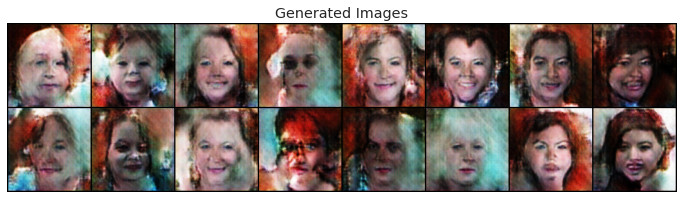

  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [31/40], loss_g: 3.4277, loss_d: 0.5020, real_score: 0.8589, fake_score: 0.1471


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [32/40], loss_g: 4.3340, loss_d: 0.3281, real_score: 0.9032, fake_score: 0.1010


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [33/40], loss_g: 4.0602, loss_d: 0.3833, real_score: 0.8839, fake_score: 0.1190


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [34/40], loss_g: 4.1583, loss_d: 0.3784, real_score: 0.8915, fake_score: 0.1105


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [35/40], loss_g: 4.4871, loss_d: 0.2440, real_score: 0.9234, fake_score: 0.0841


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [36/40], loss_g: 4.1971, loss_d: 0.3854, real_score: 0.8893, fake_score: 0.1115


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [37/40], loss_g: 4.2968, loss_d: 0.3170, real_score: 0.9041, fake_score: 0.1005


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [38/40], loss_g: 4.8468, loss_d: 0.2343, real_score: 0.9274, fake_score: 0.0742


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [39/40], loss_g: 4.8476, loss_d: 0.1949, real_score: 0.9358, fake_score: 0.0686


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [40/40], loss_g: 4.8643, loss_d: 0.2969, real_score: 0.9135, fake_score: 0.0884


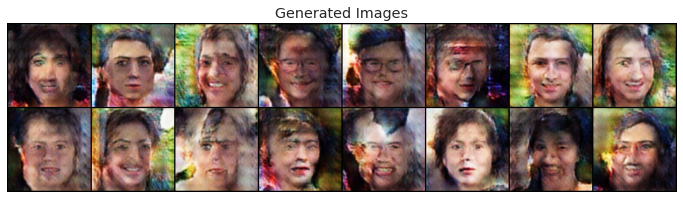

In [47]:
losses_g, losses_d, real_scores, fake_scores = fit(model, dataloader, criterion, 40, lr)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

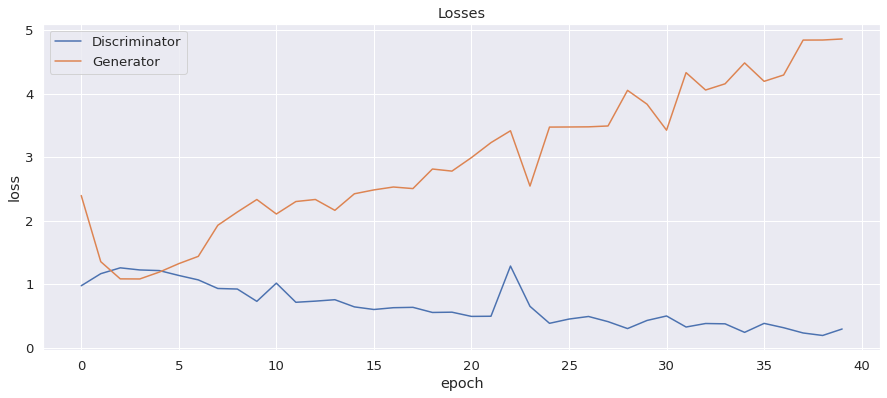

In [48]:
plt.figure(figsize=(15, 6)) 
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(('Discriminator', 'Generator'))
plt.title('Losses')
plt.show()

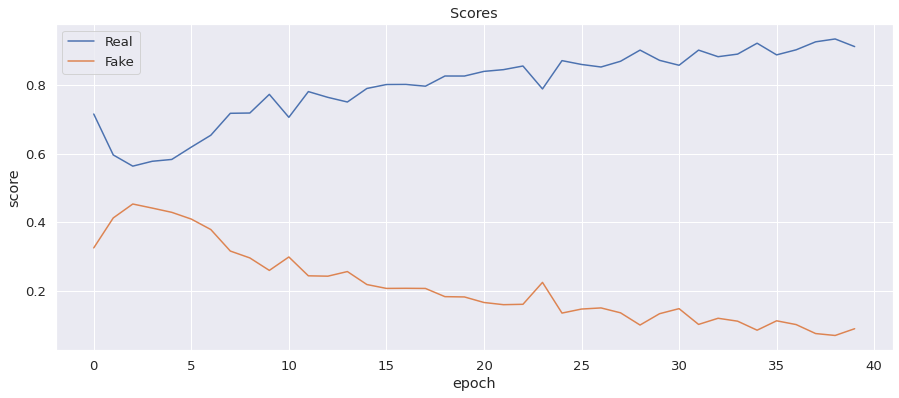

In [94]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-') 
plt.plot(fake_scores, '-') 
plt.xlabel('epoch') 
plt.ylabel('score') 
plt.legend(('Real', 'Fake')) 
plt.title('Scores');


Графики похожи на графики из семинара, но кажется, будто дискриминатор сильно давит генератор.

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [50]:
def show_images(generated):
    # TODO: show generated images
    plt.figure(figsize=(12, 12))
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(np.transpose(make_grid(generated.to(device), padding=2, normalize=True).cpu(),(1,2,0)))

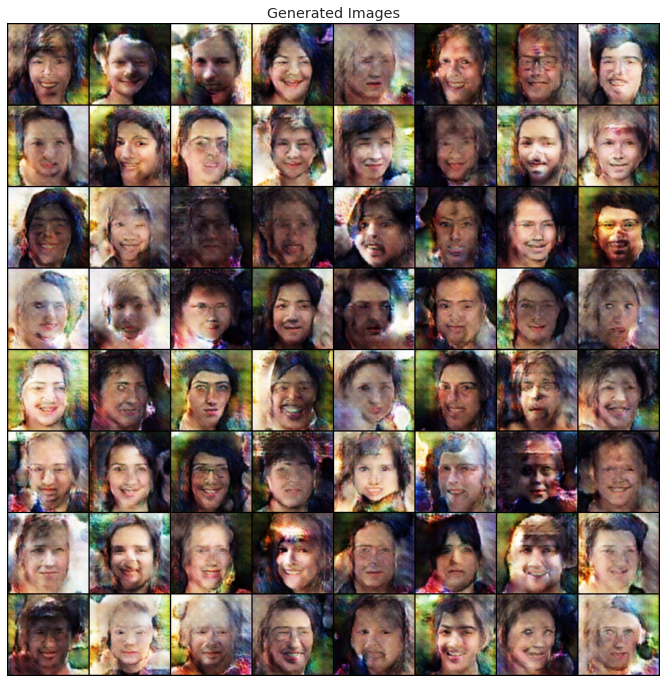

In [51]:
n_images = 64

fixed_latent = torch.randn(n_images, latent_size, device=device)
fake_images = model["generator"](fixed_latent)

show_images(fake_images)

Как вам качество получившихся изображений?

У всех этих картинок есть что-то человеческое, но это только общие черты лица, которые генератор смог выделить. Среди сгенерированных изобржений пристутсвуют, как женщины, так и мужчины, есть даже пара детей. Сами картинки похожи больше на изображения из хоррор фильмов. 

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [69]:
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score

In [58]:
n_images = 1000
fixed_latent = torch.randn(n_images, latent_size, device='cpu')

In [59]:
model["generator"].eval()
fake_images = model["generator"].to('cpu')(fixed_latent)

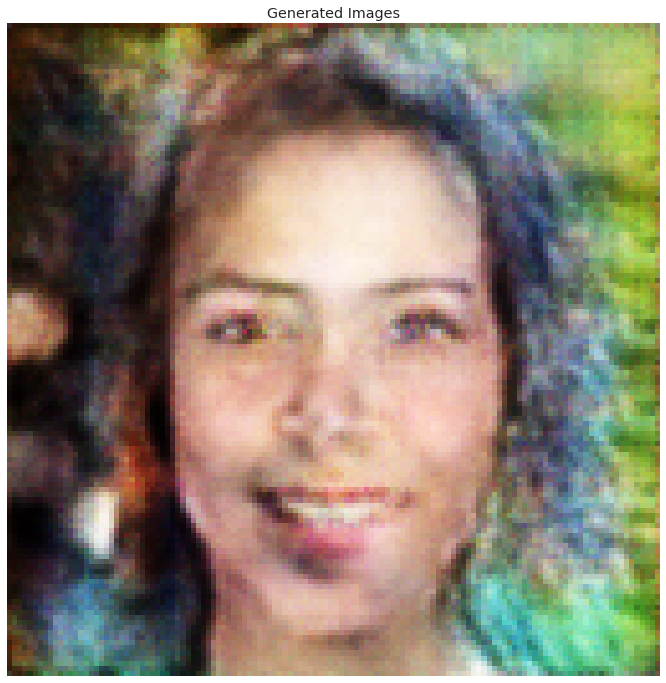

In [68]:
plt.figure(figsize=(12, 12))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(make_grid(fake_images[0].to(device), padding=2, normalize=True).cpu(),(1,2,0)))

In [70]:
reshaped_fake = fake_images.reshape(fake_images.shape[0], -1)

In [72]:
transforms = tt.Compose([tt.Resize(image_size),
                            tt.CenterCrop(image_size),
                            tt.ToTensor(),
                            tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset_ = ImageFolder(root = '/kaggle/input/faces-dataset-small', transform=transforms)
real_images = [i[0] for i in tqdm(dataset_)][:1000]

  0%|          | 0/3143 [00:00<?, ?it/s]

In [83]:
reshaped_real = torch.stack(real_images).reshape(fake_images.shape[0], -1)

In [85]:
X = torch.concat([reshaped_real.cpu(), reshaped_fake.cpu()]).detach().numpy()
y = torch.concat((torch.ones(1000), torch.zeros(1000))).numpy()

In [86]:
%%time
scores = cross_val_score(KNeighborsClassifier(n_neighbors=1), X, y, cv=LeaveOneOut())

CPU times: user 25min 10s, sys: 10min 2s, total: 35min 12s
Wall time: 21min 51s


In [87]:
scores.mean()

0.819

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Хотелось бы получить accuracy = 0.5, что означало бы, что сгенерированные и реальные изображение не отличимы для нашего дискриминатора. Этот скор обозначает, что большую часть сгенерированных изображений дискриминатор оценивает, как фейковые.

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [88]:
from sklearn.manifold import TSNE
import plotly.express as px

In [89]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(X)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [90]:
fig = px.scatter(tsne_results, x=0, y=1, color=y.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

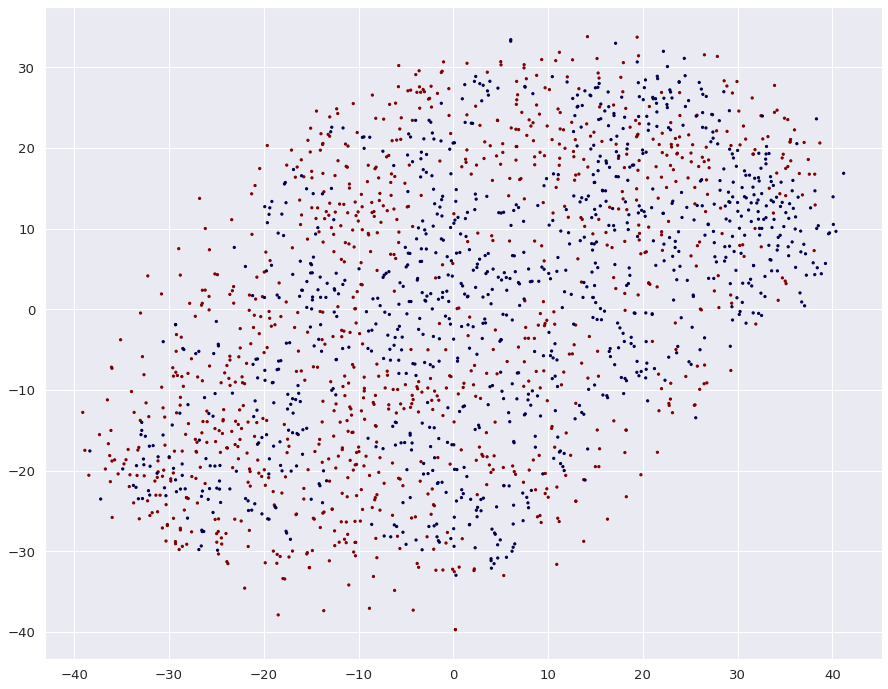

In [100]:
x1, x2 = zip(*tsne_results)
plt.figure(figsize=(15, 12))
plt.scatter(x1, x2, c=y, s=5, cmap='seismic')
plt.show()

Прокомментируйте получившийся результат:

Распределения получились похожими, то есть в двумерном пространстве картинки похожи, но некоторые скопления точек и не идеальный скор говорят о том, что дискриминатор всё ещё достаточно просто вычисляет какие картинки не настоящие.